# 4. RetinaNet


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Fangli-Ying/DeepLearning2023/blob/main/chapters/chpt2/Ch4-RetinaNet.ipynb)

在第 3 章中，我们了解了对所提供的数据进行数据增强的方法以及创建数据集类的方法。在本章中，我们将利用 torchvision 提供的单阶段模型 RetinaNet 来构建一个医用口罩检测模型。
从 4.1 节到 4.3 节，我们将以第 2 章和第 3 章所了解的内容为基础，加载数据，将其划分为训练数据和测试数据，然后定义数据集类。在 4.4 节中，我们将利用 torchvision API 来加载预训练模型。在 4.5 节中，我们将通过迁移学习来进行模型训练，然后在 4.6 节中计算预测值并查看模型性能。

## 4.1 数据下载

对于建模实践，我们将使用第 2.1 节中的代码加载数据

In [ ]:
!git clone https://github.com/Pseudo-Lab/Tutorial-Book-Utils
!python Tutorial-Book-Utils/PL_data_loader.py --data FaceMaskDetection
!unzip -q Face\ Mask\ Detection.zip

Cloning into 'Tutorial-Book-Utils'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 12 (delta 1), reused 2 (delta 0), pack-reused 0
Unpacking objects: 100% (12/12), done.
Face Mask Detection.zip is done!


## 4.2 数据分离

我们将使用第 3.3 节中确定的数据分离方法分离数据。

In [ ]:
import os
import random
import numpy as np
import shutil

print(len(os.listdir('annotations')))
print(len(os.listdir('images')))

!mkdir test_images
!mkdir test_annotations


random.seed(1234)
idx = random.sample(range(853), 170)

for img in np.array(sorted(os.listdir('images')))[idx]:
    shutil.move('images/'+img, 'test_images/'+img)

for annot in np.array(sorted(os.listdir('annotations')))[idx]:
    shutil.move('annotations/'+annot, 'test_annotations/'+annot)

print(len(os.listdir('annotations')))
print(len(os.listdir('images')))
print(len(os.listdir('test_annotations')))
print(len(os.listdir('test_images')))

853
853
683
683
170
170


## 4.3 定义数据集类


为了训练 PyTorch 模型，必须定义数据集类。用于训练 torchvision 所提供的目标检测模型的数据集类的__getitem__方法会返回图像文件以及边界框坐标。我们将应用在第 3 章中使用过的代码来定义数据集类，定义如下。

In [ ]:
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from bs4 import BeautifulSoup
from PIL import Image
import cv2
import numpy as np
import time
import torch
import torchvision
from torch.utils.data import Dataset
from torchvision import transforms
from matplotlib import pyplot as plt
import os

def generate_box(obj):
    
    xmin = float(obj.find('xmin').text)
    ymin = float(obj.find('ymin').text)
    xmax = float(obj.find('xmax').text)
    ymax = float(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]

def generate_label(obj):

    if obj.find('name').text == "with_mask":

        return 1

    elif obj.find('name').text == "mask_weared_incorrect":

        return 2

    return 0

def generate_target(file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, "html.parser")
        objects = soup.find_all("object")

        num_objs = len(objects)

        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))

        boxes = torch.as_tensor(boxes, dtype=torch.float32) 
        labels = torch.as_tensor(labels, dtype=torch.int64) 
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        
        return target

def plot_image_from_output(img, annotation):
    
    img = img.cpu().permute(1,2,0)
    
    rects = []

    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]

        if annotation['labels'][idx] == 0 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
        
        elif annotation['labels'][idx] == 1 :
            
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')
            
        else :
        
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='orange',facecolor='none')

        rects.append(rect)

    return img, rects

class MaskDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))
        self.transform = transform
        
    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        img_path = os.path.join(self.path, file_image)
        
        if 'test' in self.path:
            label_path = os.path.join("test_annotations/", file_label)
        else:
            label_path = os.path.join("annotations/", file_label)

        img = Image.open(img_path).convert("RGB")
        target = generate_target(label_path)
        
        to_tensor = torchvision.transforms.ToTensor()

        if self.transform:
            img, transform_target = self.transform(np.array(img), np.array(target['boxes']))
            target['boxes'] = torch.as_tensor(transform_target)

        # tensor로 변경
        img = to_tensor(img)


        return img, target

def collate_fn(batch):
    return tuple(zip(*batch))

dataset = MaskDataset('images/')
test_dataset = MaskDataset('test_images/')

data_loader = torch.utils.data.DataLoader(dataset, batch_size=4, collate_fn=collate_fn)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=2, collate_fn=collate_fn)

最终，利用torch.utils.data.DataLoader函数来分别定义data_loader（数据加载器）和test_data_loader（测试数据加载器），以便能够按批次加载训练数据和测试数据。

## 4.4 加载模型


torchvision提供了能够轻松加载用于解决各类计算机视觉问题的深度学习模型的应用程序编程接口（API）。我们将利用torchvision.models模块来加载 RetinaNet 模型。由于 RetinaNet 在torchvision 0.8.0 及以上版本中才提供，所以我们利用下面的代码来使torchvision版本与之匹配。

In [ ]:
!pip install torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 7.6MB 11.1MB/s 


In [ ]:
import torchvision
import torch

In [ ]:
torchvision.__version__

'0.8.1+cu101'

通过torchvision.__version__命令，可以确认在当前运行的 cuda 10.1 版本环境中，已经安装了torchvision 0.8.1 版本。接下来，运行下面的代码来加载 RetinaNet 模型。由于人脸口罩检测数据集存在 3 个类别，所以将num_classes参数定义为 3，并且由于要进行迁移学习，骨干（backbone）结构将采用预训练的权重，而其他权重则以初始化状态进行获取。该骨干结构是在以目标检测数据集而闻名的 COCO 数据集上进行预训练的。

In [ ]:
retina = torchvision.models.detection.retinanet_resnet50_fpn(num_classes = 3, pretrained=False, pretrained_backbone = True)

## 4.5 迁移学习

加载模型后，使用下面的代码执行迁移学习。

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_epochs = 30
retina.to(device)
    
# parameters
params = [p for p in retina.parameters() if p.requires_grad] # gradient calculation이 필요한 params만 추출
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)

len_dataloader = len(data_loader)

# epoch 당 약 4분 소요
for epoch in range(num_epochs):
    start = time.time()
    retina.train()

    i = 0    
    epoch_loss = 0
    for images, targets in data_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = retina(images, targets) 

        losses = sum(loss for loss in loss_dict.values()) 

        i += 1

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        epoch_loss += losses 
    print(epoch_loss, f'time: {time.time() - start}')

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


tensor(285.9670, device='cuda:0', grad_fn=<AddBackward0>) time: 242.22558188438416
tensor(268.1001, device='cuda:0', grad_fn=<AddBackward0>) time: 251.5482075214386
tensor(248.4554, device='cuda:0', grad_fn=<AddBackward0>) time: 248.92862486839294
tensor(233.0612, device='cuda:0', grad_fn=<AddBackward0>) time: 249.69438576698303
tensor(234.2285, device='cuda:0', grad_fn=<AddBackward0>) time: 247.88670659065247
tensor(202.4744, device='cuda:0', grad_fn=<AddBackward0>) time: 249.68517541885376
tensor(172.9739, device='cuda:0', grad_fn=<AddBackward0>) time: 250.47061586380005
tensor(125.8968, device='cuda:0', grad_fn=<AddBackward0>) time: 251.4771168231964
tensor(102.0443, device='cuda:0', grad_fn=<AddBackward0>) time: 251.20848298072815
tensor(88.1749, device='cuda:0', grad_fn=<AddBackward0>) time: 251.144877910614
tensor(78.1594, device='cuda:0', grad_fn=<AddBackward0>) time: 251.8066761493683
tensor(73.6921, device='cuda:0', grad_fn=<AddBackward0>) time: 251.669575214386
tensor(69.6965

要重用模型，请运行下面的代码来保存学习到的权重。您可以使用 “torch.save” 函数将学习到的权重保存在指定位置。

In [ ]:
torch.save(retina.state_dict(),f'retina_{num_epochs}.pt')

In [ ]:
retina.load_state_dict(torch.load(f'retina_{num_epochs}.pt'))

<All keys matched successfully>

加载学习到的权重时，可以使用 'load_state_dics' 和 'torch. load' 函数，如果指定新的视网膜变量，则必须将模型上传到 GPU 内存进行 GPU 计算。

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
retina.to(device)

## 4.6 预测

如果训练完成，我们将检查预测结果。从 test_data_loader 中加载数据并将其放入模型中进行学习后，我们将分别可视化预测结果和实际值。首先，我们将定义预测所需的函数。

In [ ]:
def make_prediction(model, img, threshold):
    model.eval()
    preds = model(img)
    for id in range(len(preds)) :
        idx_list = []

        for idx, score in enumerate(preds[id]['scores']) :
            if score > threshold : #threshold 넘는 idx 구함
                idx_list.append(idx)

        preds[id]['boxes'] = preds[id]['boxes'][idx_list]
        preds[id]['labels'] = preds[id]['labels'][idx_list]
        preds[id]['scores'] = preds[id]['scores'][idx_list]


    return preds

make_prediction函数中存储着利用已训练的深度学习模型进行预测的算法。通过调整threshold（阈值）参数，只选择可信度在一定水平以上的边界框。通常最终会选择 0.5 及以上的值。接下来，我们将利用for循环对test_data_loader中所有的数据进行预测。

In [ ]:
from tqdm import tqdm

labels = []
preds_adj_all = []
annot_all = []

for im, annot in tqdm(test_data_loader, position = 0, leave = True):
    im = list(img.to(device) for img in im)
    #annot = [{k: v.to(device) for k, v in t.items()} for t in annot]

    for t in annot:
        labels += t['labels']

    with torch.no_grad():
        preds_adj = make_prediction(retina, im, 0.5)
        preds_adj = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in preds_adj]
        preds_adj_all.append(preds_adj)
        annot_all.append(annot)


100%|██████████| 85/85 [00:24<00:00,  3.47it/s]



正在利用tqdm函数来展示进展情况。所有预测值都已存储在preds_adj_all变量中。接下来，我们将对实际的边界框和预测的边界框进行可视化展示。

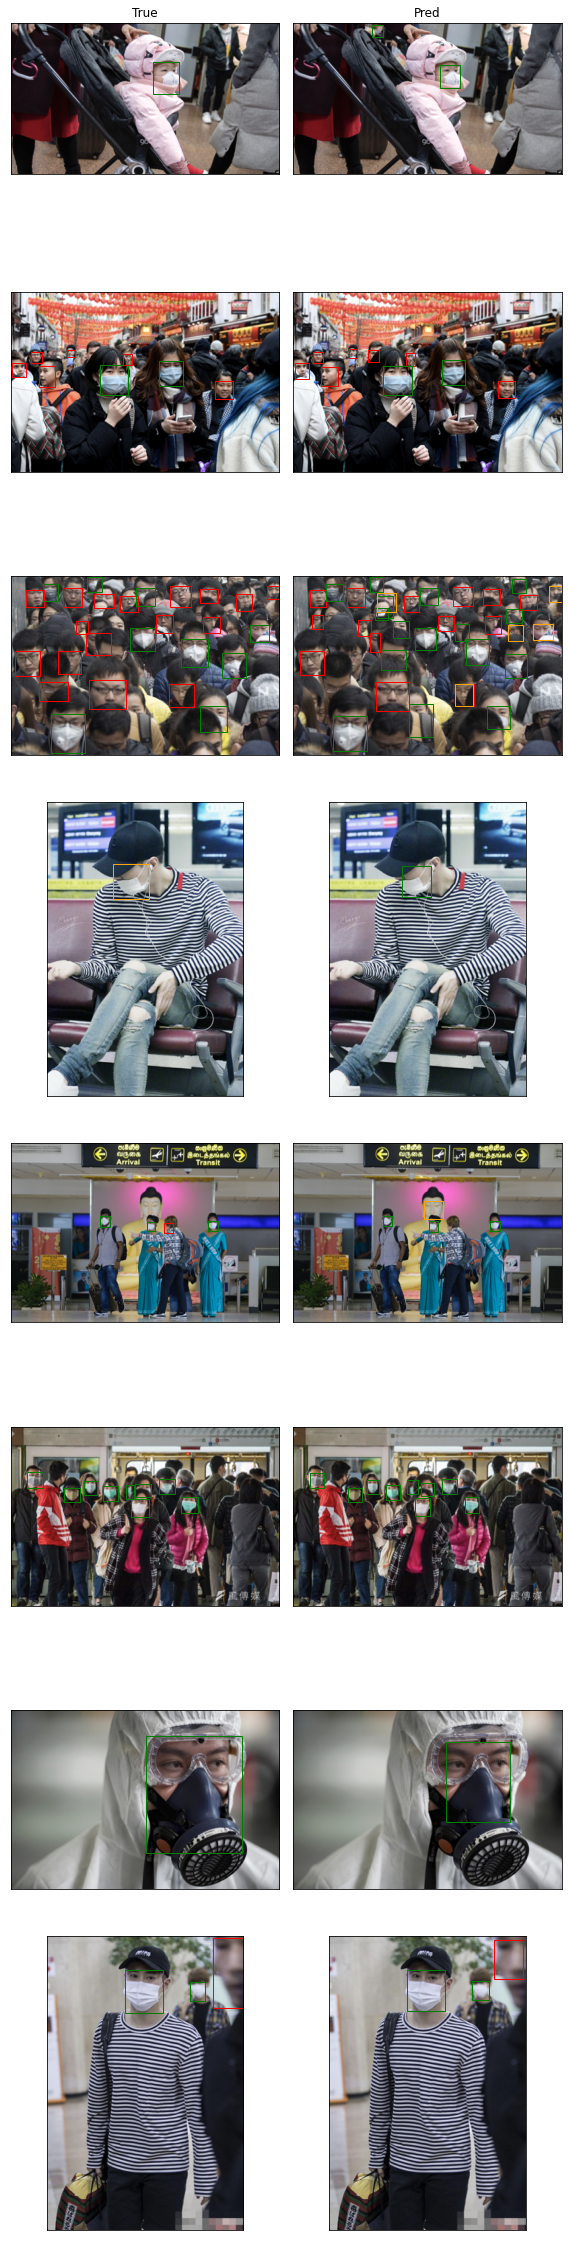

In [ ]:
nrows = 8
ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4, nrows*4))

batch_i = 0
for im, annot in test_data_loader:
    pos = batch_i * 4 + 1
    for sample_i in range(len(im)) :
        
        img, rects = plot_image_from_output(im[sample_i], annot[sample_i])
        axes[(pos)//2, 1-((pos)%2)].imshow(img)
        for rect in rects:
            axes[(pos)//2, 1-((pos)%2)].add_patch(rect)
        
        img, rects = plot_image_from_output(im[sample_i], preds_adj_all[batch_i][sample_i])
        axes[(pos)//2, 1-((pos+1)%2)].imshow(img)
        for rect in rects:
            axes[(pos)//2, 1-((pos+1)%2)].add_patch(rect)

        pos += 2

    batch_i += 1
    if batch_i == 4:
        break

# xtick, ytick 제거
for idx, ax in enumerate(axes.flat):
    ax.set_xticks([])
    ax.set_yticks([])

colnames = ['True', 'Pred']

for idx, ax in enumerate(axes[0]):
    ax.set_title(colnames[idx])

plt.tight_layout()
plt.show()

利用for循环对 4 个批次，总共 8 张图像的实际值和预测值进行了可视化展示。左边一列是实际边界框的标签及位置，右边一列是模型的预测值。可以观察到，模型能较好地检测出佩戴口罩的人（绿色），而对于未佩戴口罩的人（红色），偶尔会出现将其检测为佩戴口罩不正确（橙色）的情况。为了评估整体的模型性能，我们来计算平均精度均值（mean Average Precision，mAP）吧。mAP 是用于评估目标检测模型的指标。
在下载数据时所加载的 “Tutorial-Book-Utils” 文件夹内有 “utils_ObjectDetection.py” 文件。我们将利用该模块内的函数来计算 mAP。首先，加载 “utils_ObjectDetection.py” 模块。


In [ ]:
%cd Tutorial-Book-Utils/
import utils_ObjectDetection as utils

/content/Tutorial-Book-Utils


In [ ]:
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += utils.get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i], iou_threshold=0.5) 

将计算每个批次的平均精度均值（mAP）所需的信息存储在sample_metrics中，然后利用ap_per_class函数来计算 mAP。

In [ ]:
true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # 배치가 전부 합쳐짐
precision, recall, AP, f1, ap_class = utils.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')

mAP : 0.5824690281035101
AP : tensor([0.7684, 0.9188, 0.0603], dtype=torch.float64)


对结果进行解读可知，对于 0 号类别（即未佩戴口罩的对象），平均精度（AP）为 0.7684；对于 1 号类别（即佩戴口罩的对象），平均精度为 0.9188；对于 2 号类别（即口罩佩戴不正确的对象），平均精度为 0.06。
到目前为止，我们已经针对 RetinaNet 进行了迁移学习，构建出了医用口罩检测模型。在下一章中，我们将利用两阶段检测器 Faster R-CNN 来提高检测性能。